# Import các thư viện cần thiết

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

In [6]:
# Config GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Download, xử lý bộ dữ liệu MNIST

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])])

In [8]:
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

100%|██████████████████████████████████████████████████████████████████| 9912422/9912422 [00:00<00:00, 36447669.88it/s]


Extracting ./mnist_data/MNIST\raw\train-images-idx3-ubyte.gz to ./mnist_data/MNIST\raw



100%|████████████████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<?, ?it/s]


Extracting ./mnist_data/MNIST\raw\train-labels-idx1-ubyte.gz to ./mnist_data/MNIST\raw



100%|██████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 16129117.52it/s]


Extracting ./mnist_data/MNIST\raw\t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST\raw



100%|██████████████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST\raw\t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST\raw



In [9]:
batch_size = 100

In [10]:
# Data Loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Visualize samples thực từ dataset

In [11]:
img, label = train_dataset[0]
print('Label: ', label)
print(img[:,10:15,10:15])

Label:  5
tensor([[[-0.9922,  0.2078,  0.9843, -0.2941, -1.0000],
         [-1.0000,  0.0902,  0.9843,  0.4902, -0.9843],
         [-1.0000, -0.9137,  0.4902,  0.9843, -0.4510],
         [-1.0000, -1.0000, -0.7255,  0.8902,  0.7647],
         [-1.0000, -1.0000, -1.0000, -0.3647,  0.8824]]])


Label: 5


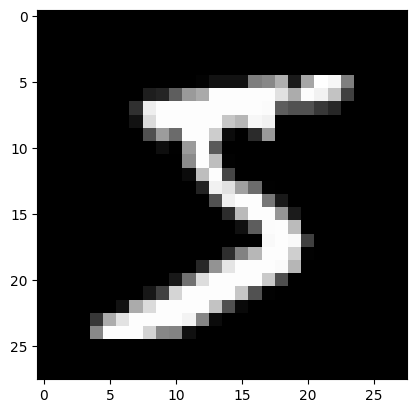

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

# Xây dựng mô hình Generator

In [13]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)

    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))

# Xây dựng mô hình Discriminator

In [14]:
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)

    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

In [15]:
# Khởi tạo input z (random noise) có chiều là 100
z_dim = 100

In [16]:
# Tính chiều của mỗi ảnh trong tập MNIST 28x28=784
mnist_dim = train_dataset.train_data.size(1) * train_dataset.train_data.size(2)
mnist_dim

C:\Program Files\Python39\lib\site-packages\torchvision\datasets\mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


784

In [17]:
#  Khởi tạo Generator, Discriminator network
G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)

# Loss function và tham số cho quá trình training

In [18]:
criterion = nn.BCELoss()

# optimizer
lr = 0.0002
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)

In [19]:
def discriminator_train(x):

    D.zero_grad()

    # train discriminator on real data
    x_real, y_real = x.view(-1, mnist_dim), torch.ones(batch_size, 1)
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # train discriminator on fake data
    z = Variable(torch.randn(batch_size, z_dim).to(device))
    x_fake, y_fake = G(z), Variable(torch.zeros(batch_size, 1).to(device))

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()

    return  D_loss.data.item()

In [20]:
def generator_train(x):
    G.zero_grad()

    z = Variable(torch.randn(batch_size, z_dim).to(device))
    y = Variable(torch.ones(batch_size, 1).to(device))

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()

    return G_loss.data.item()

#Training

In [21]:
n_epoch = 200
for epoch in range(1, n_epoch+1):
    D_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(train_loader):
        # Discriminator training trước, Generator training sau
        D_losses.append(discriminator_train(x))
        G_losses.append(generator_train(x))

    print('[%d/%d]: Discriminator loss: %.3f, Generator loss: %.3f' % (
            (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))

[1/200]: Discriminator loss: 0.844, Generator loss: 2.944
[2/200]: Discriminator loss: 1.175, Generator loss: 1.391


KeyboardInterrupt: 

# Lưu checkpoint

In [ ]:
# Save the model checkpoints
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

# Inference

In [ ]:
#Load checkpoint nếu bỏ qua bước trainning
G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim)
G.load_state_dict(torch.load('G.ckpt'))
G.to(device)
G.eval()

D = Discriminator(d_input_dim = mnist_dim)
D.load_state_dict(torch.load('D.ckpt'))
D.to(device)
D.eval()

In [ ]:
with torch.no_grad():
    test_z = Variable(torch.randn(batch_size, z_dim).to(device))
    generated = G(test_z)

    save_image(generated.view(generated.size(0), 1, 28, 28), './sample_' + '.png')

In [ ]:
#Visualize kết quả từ mạng Generator sau quá trình training
plt.imshow(plt.imread('./sample_.png'))